# Fixed Backbone design from LM

This notebook demonstrates the Fixed Backbone design task from the paper [Language models generalize beyond natural proteins
](https://www.biorxiv.org/content/10.1101/2022.12.21.521521v1).

Given an input structure as .pdb file, the LM is used iteratively in an MCMC optimization to find a sequence that folds to that structure


In [1]:
# First install additional dependencies
!pip install -r additional_requirements.txt


/bin/bash: /home/wadh6511/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# Imports
import os
import time
import hydra
import py3Dmol
from lm_design import Designer

# Params
pdb_fn = os.getcwd() + '/2N2U.pdb'
seed = 0  # Use different seeds to get different sequence designs for the same structure
TASK = "fixedbb"

/home/wadh6511/Kode/Hackathon/thermo_stabiliser/examples/lm-design/lm_design.py:475: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="conf/", config_name="config")


In [3]:
# Load hydra config from config.yaml
with hydra.initialize_config_module(config_module="conf"):
    cfg = hydra.compose(
        config_name="config", 
        overrides=[
            f"task={TASK}", 
            f"seed={seed}", 
            f"pdb_fn={pdb_fn}", 
            # 'tasks.fixedbb.num_iter=100'  # DEBUG - use a smaller number of iterations
        ])

/home/wadh6511/miniconda3/envs/esmfold/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  


In [4]:
# Create a designer from configuration
des = Designer(cfg, pdb_fn)

In [65]:
import pandas as pd
import numpy as np
logs_all = pd.read_csv('logs_all.csv')
logs_all['t'] = np.arange(len(logs_all))

In [66]:
v = ''
for ii, i in enumerate(logs_all['seq']):
    v += f'>{ii}\n' + i + '\n'
text_file = open("test.txt", "w")
n = text_file.write(v)
text_file.close()

In [67]:
logs_all['seq'].iloc[0]

'MVDLKIDVSDDEEAEKIIREIREQWPKATVTRTNGDIKLDAQTEKEAEKMEKAVKKVKPNATIRKTG'

In [68]:
logs_all['seq'].iloc[80]

'MVLLKNWSKDDKTYQYIGGHLRPKHNIGTRTRTAWNIYPYAKTEKVMEDTEIRKMVAKGNWMSKGSH'

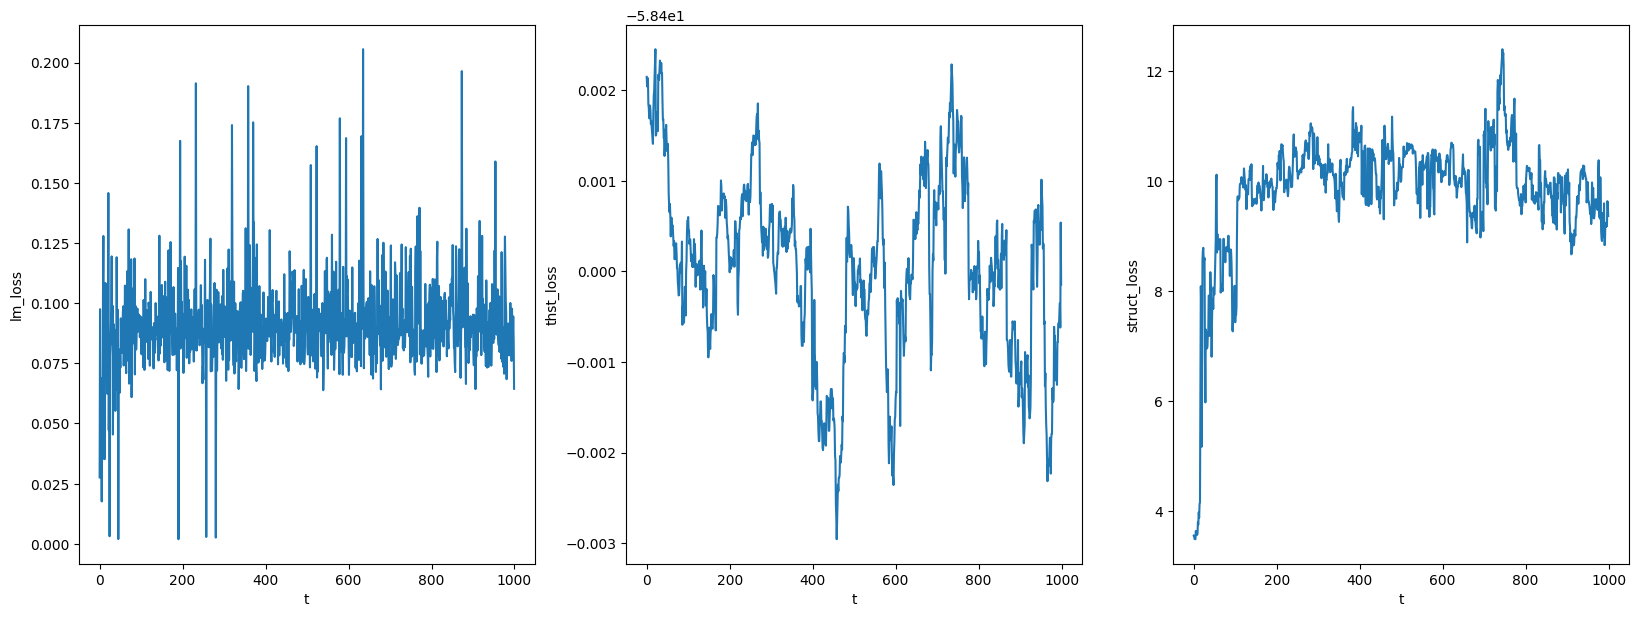

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 7))
for i, l in enumerate(['lm_loss', 'thst_loss', 'struct_loss']):
    ax = plt.subplot(1,3,i+1)
    sns.lineplot(logs_all, y=l, x='t')


In [7]:

# Run the designer
start_time = time.time()
des.run_from_cfg()
print("finished after %s hours", (time.time() - start_time) / 3600)

  0%|          | 0/2 [00:00<?, ?it/s]Some weights of the model checkpoint at facebook/esm2_t30_150M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.den

TypeError: expected np.ndarray (got SequenceClassifierOutput)

: 

In [ ]:
print("Output seq:", des.output_seq)

In [ ]:

# Fold output with ESMFold API
output_seq = des.output_seq
# Fold with api:
#  curl -X POST --data "GENGEIPLEIRATTGAEVDTRAVTAVEMTEGTLGIFRLPEEDYTALENFRYNRVAGENWKPASTVIYVGGTYARLCAYAPYNSVEFKNSSLKTEAGLTMQTYAAEKDMRFAVSGGDEVWKKTPTANFELKRAYARLVLSVVRDATYPNTCKITKAKIEAFTGNIITANTVDISTGTEGSGTQTPQYIHTVTTGLKDGFAIGLPQQTFSGGVVLTLTVDGMEYSVTIPANKLSTFVRGTKYIVSLAVKGGKLTLMSDKILIDKDWAEVQTGTGGSGDDYDTSFN" https://api.esmatlas.com/foldSequence/v1/pdb/
import requests
import json
url = 'https://api.esmatlas.com/foldSequence/v1/pdb/'
r = requests.post(url, data=output_seq)
output_struct = r.text



In [ ]:
# Visualize output structure
view = py3Dmol.view(width=800, height=800)
view.addModel(output_struct, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()


In [ ]:
des.x_logits.shape

In [ ]:
# Visualize wild type structure
wt_struct_file = pdb_fn
view = py3Dmol.view(width=800, height=800)
view.addModel(open(wt_struct_file).read(), 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()